<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Density Estimation: Gaussian Mixture Models

Here we'll explore **Gaussian Mixture Models**, which is an unsupervised clustering & density estimation technique.

We'll start with our standard set of initial imports

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

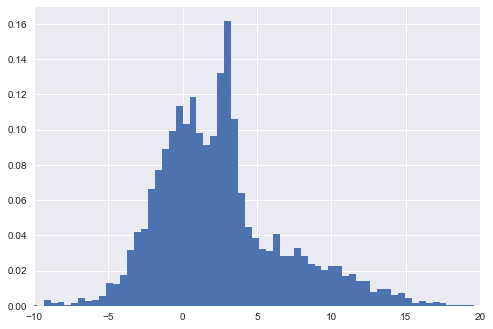

In [10]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation

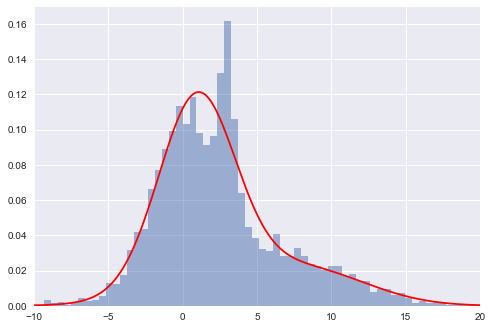

In [16]:
from sklearn.mixture import GMM
X = x[:, np.newaxis]
clf = GMM(4, n_iter=500, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [4]:
clf.means_

array([[ 3.95722594],
       [ 0.25029969],
       [ 1.45154151],
       [ 9.56336527]])

In [5]:
clf.covars_

array([[ 23.14843932],
       [  6.46691735],
       [  5.79759101],
       [ 14.80680322]])

In [6]:
clf.weights_

array([ 0.21904396,  0.31750123,  0.35379208,  0.10966273])

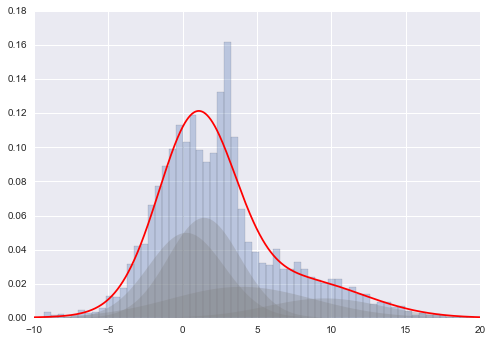

In [7]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [8]:
print(clf.bic(X))
print(clf.aic(X))

25911.2121006
25840.4401732


Let's take a look at these as a function of the number of gaussians:

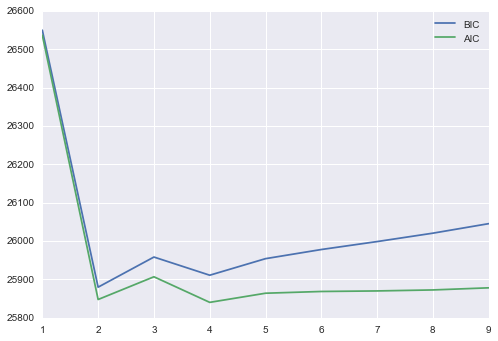

In [9]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, n_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred.

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [17]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation

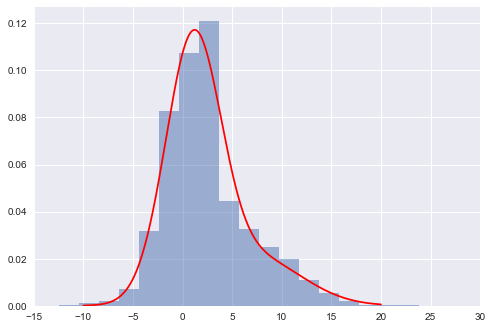

In [18]:
clf = GMM(4, n_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(y, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

/Users/austin/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


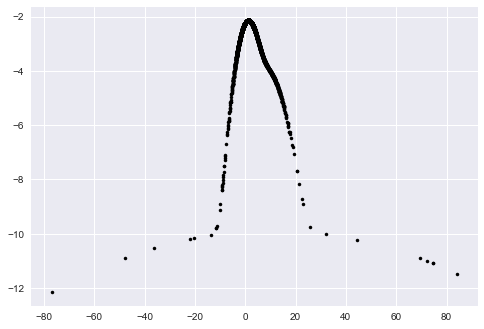

In [19]:
log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [20]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607 2732
 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2135 2163 2222 2496 2732 2893 2897 3067 3173 3253
 3468 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [21]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [22]:
set(detected_outliers) - set(true_outliers)

{3067, 3173, 3253, 3483}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

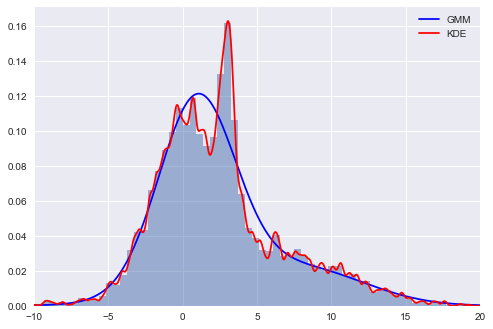

In [23]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.